# **OPEC Sentiment Analysis & Commodity Price Forecasting**
### *Using GPT, FinBERT, and Market Data (2019–2025)*

---

## **Objective**
This notebook builds predictive models that estimate **future commodity prices** (Polypropylene or Brent) using:

- **GPT-generated sentiment shift scores**  
- **FinBERT-based section sentiment**  
- **Keyword intensity features**  
- **Crude oil, WTI, Natural Gas, and Polypropylene price data**

This is the final modeling step of the OPEC Sentiment Project.

---

## **Dataset Used**
This notebook uses the output of pre-processing pipelines:

- `opec_comparison_scores_gpt.csv`  
- `opec_features_finbert_chunked.csv`  
- `master_monthly_prices.csv`  
- `master_opec_price_model_dataset.csv`

All datasets have already been aligned to **month-end** for consistency.

---

## **Modeling Tasks**
1. Load and explore the combined dataset  
2. Inspect correlations between sentiment and price changes  
3. Build machine learning models:
   - Linear Regression
   - Random Forest
   - XGBoost  
4. Evaluate performance  
5. Forecast next month’s commodity price  
6. Visualize predictions vs. actuals  


In [5]:
!pip install scikit-learn --upgrade


In [11]:
import sys
!"{sys.executable}" -m pip install scikit-learn
!"{sys.executable}" -m pip install xgboost



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.3/72.0 MB 7.8 MB/s eta 0:00:10
   -- ------------------------------------- 5.0/72.0 MB 13.7 MB/s eta 0:00:05
   ---- ----------------------------------- 8.9/72.0 MB 15.5 MB/s eta 0:00:05
   ------- -------------------------------- 13.9/72.0 MB 19.1 MB/s eta 0:00:04
   -------- ------------------------------- 15.5/72.0 MB 16.0 MB/s eta 0:00:04
   ---------- ----------------------------- 18.9/72.0 MB 15.7 MB/s eta 0:00:04
   ------------ --------------------------- 21.8/72.0 MB 15.6 MB/s eta 0:00:04
   ------------- -------------------------- 23.9/72.0 MB 14.9 MB/s eta 0:00:04
   -------------- ------------------------- 26.0/72.0 MB 14.2 MB/s eta 0:00:04
   --------------- ------------------------ 27.8/72.0 MB 13.8 MB/s eta 0:00:04
   ----------------- ---------------------- 30.9/72.0 MB 13.8 MB/s eta 0:00:03
   ------------------ --------------------- 32.8/72.0 MB 13.4 MB/


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Optional: clean plot style
plt.style.use("seaborn-v0_8")


In [13]:
df = pd.read_csv("../data/processed/master_opec_price_model_dataset.csv")
df["date"] = pd.to_datetime(df["date"])

df.head(), df.shape


(        date  comparison_score  finbert_sentiment  supply_up  supply_down  \
 0 2019-01-31               NaN           0.186915    0.01477      0.00633   
 1 2019-01-31               NaN           0.220044    0.00217      0.00316   
 2 2019-01-31               NaN           0.606347    0.00000      0.00692   
 3 2019-01-31               NaN          -0.572259    0.00037      0.00000   
 4 2019-02-28              -0.7           0.044548    0.00636      0.00636   
 
    demand_up  demand_down  price_up  price_down   PP_EU  Brent    WTI  NatGas  \
 0    0.00844      0.00633       0.0     0.00211  1385.0  59.77  51.07    3.15   
 1    0.00049      0.00345       0.0     0.00059  1385.0  59.77  51.07    3.15   
 2    0.00000      0.00692       0.0     0.00346  1385.0  59.77  51.07    3.15   
 3    0.00000      0.00074       0.0     0.00000  1385.0  59.77  51.07    3.15   
 4    0.00000      0.00636       0.0     0.00000  1385.0  63.63  54.53    2.69   
 
    PP_EU_next_month  Brent_next_mon

##  Dataset Overview

Each row represents a **month-end observation** combining:

### **Sentiment Features**
- `comparison_score` → Month-to-month sentiment shift (GPT)
- `finbert_sentiment` → Section sentiment (FinBERT)
- Keyword densities:
  - `supply_up`, `supply_down`
  - `demand_up`, `demand_down`
  - `price_up`, `price_down`

### **Market Features**
- Polypropylene price (`PP_EU`)
- Brent price (`Brent`)
- WTI price (`WTI`)
- Natural gas price (`NatGas`)

### **Prediction Targets**
- `PP_EU_next_month`
- `Brent_next_month`

We now check basic dataset statistics.


In [14]:
df.describe().T


,count,mean,min,25%,50%,75%,max,std
date,332,2022-07-01 04:02:53.493975808,2019-01-31 00:00:00,2020-09-30 00:00:00,2022-06-30 00:00:00,2024-03-31 00:00:00,2025-11-30 00:00:00,NaN
comparison_score,328.0,0.129268,-0.9,-0.4,0.4,0.6,0.8,0.557076
finbert_sentiment,332.0,-0.053317,-0.999998,-0.529536,0.099448,0.288714,0.963167,0.510278
supply_up,332.0,0.006017,0.0,0.00052,0.00189,0.00491,0.04724,0.009614
supply_down,332.0,0.002185,0.0,0.0,0.00174,0.003257,0.02386,0.002816
demand_up,332.0,0.002422,0.0,0.0,0.000545,0.001978,0.02469,0.0044
demand_down,332.0,0.002271,0.0,0.0,0.001895,0.003412,0.0194,0.002686
price_up,332.0,0.00022,0.0,0.0,0.0,0.0001,0.00348,0.00062
price_down,332.0,0.000389,0.0,0.0,0.0,0.00027,0.00707,0.00099
PP_EU,328.0,1562.5,995.0,1385.0,1451.25,1720.0,2475.0,370.811574


##  Correlation Heatmap

This heatmap reveals:
- Which sentiment features correlate with price movement  
- Whether supply/demand keywords show predictive power  
- How strongly GPT scores relate to market direction  
- How price variables relate to each other  

This helps guide model selection and feature engineering.


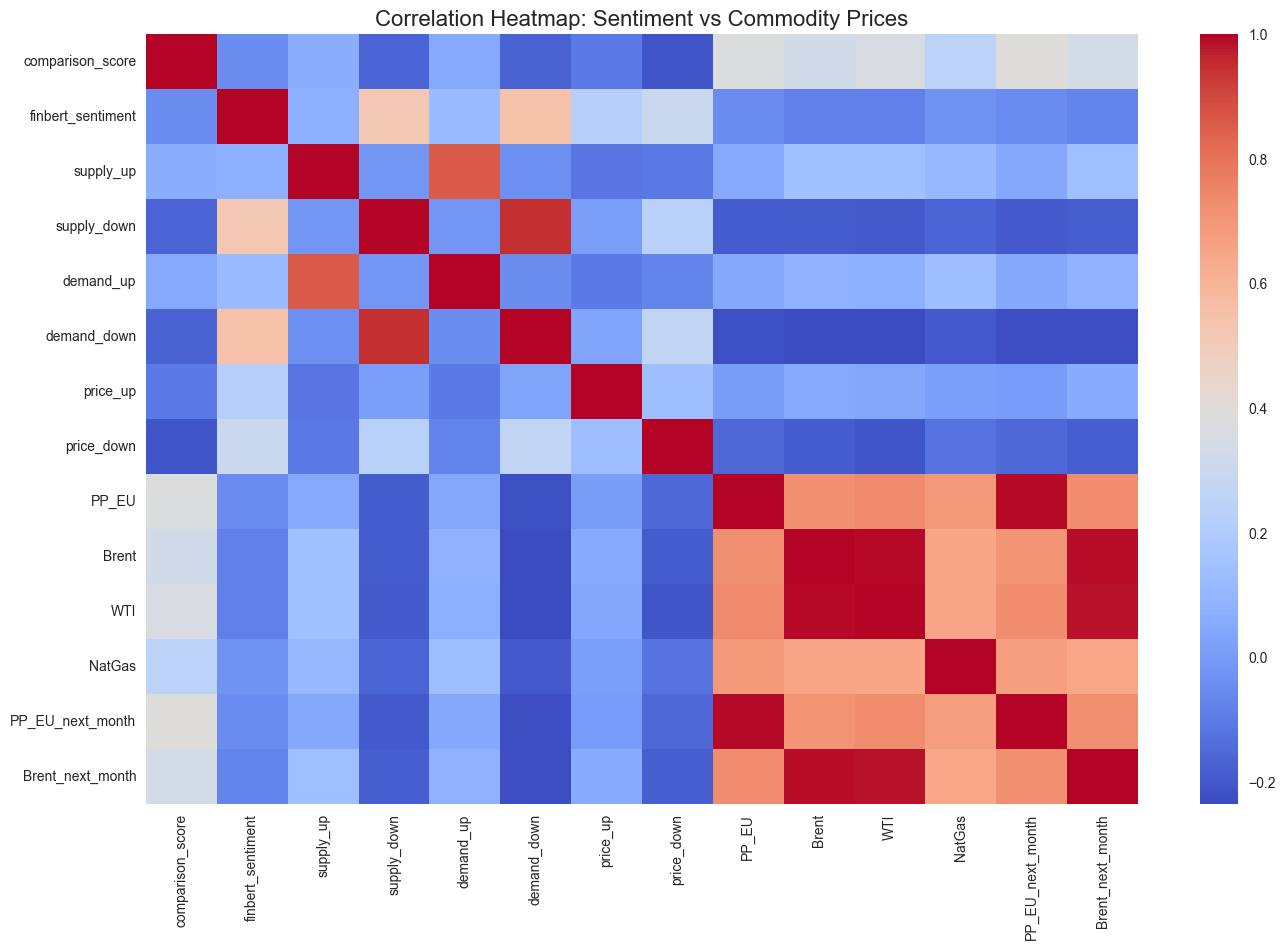

In [15]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap: Sentiment vs Commodity Prices", fontsize=16)
plt.show()
